Group 3
Miquel Romero Blanch NIU 1528716
Josep Bravo Bravo NIU 1526453

In [1]:
import cv2
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 1. Read data
Let us first read the train and test files

In [2]:
def read_dataset():
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
    test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))
    images_filenames = np.array(train_images_filenames + test_images_filenames)
    labels = np.array(train_labels + test_labels)
    return images_filenames, labels

In [3]:
def read_train_test():
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
    test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))
    return train_images_filenames, test_images_filenames, train_labels, test_labels

# 2. Descriptor
We create a KAZE/SIFT/.... object detector and descriptor

In [4]:
def compute_dense_keypoints(img, step):
    keypoints = []
    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))
    return keypoints

In [5]:
def dense_sift(img, keypoints, n_features=None):
    detector = cv2.SIFT_create(n_features)
    return detector.compute(img, keypoints)

def sift(img, n_features=None):
    detector = cv2.SIFT_create(n_features)
    return detector.detectAndCompute(img, None)

def kaze(img):
    detector = cv2.KAZE_create(threshold=0.0001)
    return detector.detectAndCompute(img, None)

def akaze(img):
    detector = cv2.AKAZE_create(threshold=0.0001)
    return detector.detectAndCompute(img, None)

def orb(img, n_features=None):
    detector = cv2.ORB_create(n_features)
    return detector.detectAndCompute(img, None)

Compute descriptors depending on specified type

In [6]:
def get_descriptor(im, des_type, step, n_features=None):
    if des_type == "DSIFT":  # Dense SIFT
        kpt = compute_dense_keypoints(im, step)
        kpt, des = dense_sift(im, kpt, n_features)
    elif des_type == "SIFT":
        kpt, des = sift(im, n_features)
    elif des_type == "KAZE":
        kpt, des = kaze(im)
    elif des_type == "AKAZE":
        kpt, des = akaze(im)
    elif des_type == "ORB":
        kpt, des = orb(im, n_features)
    return kpt, des

We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [7]:
def compute_descriptors(images_filenames, labels, des_type, step=None, n_features=None, scale_percent = 100):
    descriptors = []
    label_per_descriptor = []
    for filename,label in zip(images_filenames,labels):
        ima=cv2.imread(filename)
        if scale_percent == 100:
            width = int(ima.shape[1] * scale_percent / 100)
            height = int(ima.shape[0] * scale_percent / 100)
            dim = (width, height)
            ima = cv2.resize(ima, dim, interpolation = cv2.INTER_LINEAR)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=get_descriptor(gray, des_type, step, n_features=n_features)
        descriptors.append(des)
        label_per_descriptor.append(label)
    return np.array(descriptors, dtype=object), np.array(label_per_descriptor)

In [47]:
def compute_descriptors_pyramid(images_filenames, labels, des_type, step=None, n_features=None, level=2):
    descriptors = []
    label_per_descriptor = []
    n_cols_rows = 2 ** (level - 1)
    for filename,label in zip(images_filenames,labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        #spatial pyramid here
        des_c = None
        for i in range(n_cols_rows):
            for j in range(n_cols_rows):
                gray_block = gray[int(i * (gray.shape[0] / n_cols_rows)):int((i + 1) * (gray.shape[0] / n_cols_rows)),
                              int(j * (gray.shape[1] / n_cols_rows)):int((j + 1) * (gray.shape[1] / n_cols_rows))]
                kpt,des=get_descriptor(gray_block, des_type, step, n_features=n_features)
                if des_c is None:
                    des_c = des
                else:
                    des_c = np.concatenate((des_c, des), axis=0)
        descriptors.append(des_c)
        label_per_descriptor.append(label)
    return np.array(descriptors, dtype=object), np.array(label_per_descriptor)

# 3. Clustering
We now compute a k-means clustering on the descriptor space

In [8]:
def compute_codebook(D, k):
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    return codebook

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [9]:
def compute_visual_words(codebook, Train_descriptors, k):
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    return visual_words

# 4. Plots

In [10]:
def plot_ROC(test_labels, predictions):
    # Convert the test labels and predictions to binary format
    lb = LabelBinarizer()
    test_labels_bin = lb.fit_transform(test_labels)
    predictions_bin = lb.transform(predictions)

    # Compute the ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions_bin[:, i])
        roc_auc[i] = roc_auc_score(test_labels_bin[:, i], predictions_bin[:, i])

    # Plot the ROC curve for each class
    colors = ['blue', 'red', 'green', 'yellow', "cyan", "magenta", "black",
              "#c37500"]  # Add as many colors as classes you have
    for i, color in zip(range(len(lb.classes_)), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(lb.classes_[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for multiple classes')
    plt.legend(loc="lower right")
    plt.show()


def plot_PR(test_labels, predictions):
    # Convert the test labels and predictions to binary format
    lb = LabelBinarizer()
    test_labels_bin = lb.fit_transform(test_labels)
    predictions_bin = lb.transform(predictions)
    # Compute the precision-recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(lb.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], predictions_bin[:, i])
        average_precision[i] = average_precision_score(test_labels_bin[:, i], predictions_bin[:, i])

    # Plot the PR curve for each class
    colors = ['blue', 'red', 'green', 'yellow', "cyan", "magenta", "black",
              "#c37500"]  # Add as many colors as classes you have
    for i, color in zip(range(len(lb.classes_)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='PR curve of class {0} (AP = {1:0.2f})'.format(lb.classes_[i], average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")
    plt.title('Precision-Recall curve for multiple classes')
    plt.show()

# 5. Classifiers (KNN & SVM) - Train&Test

In [40]:
def train(train_labels, visual_words, n, distance="euclidean", kernel="linear", classifier="svm"):
    if classifier == "knn":
        model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, metric=distance)
        model.fit(visual_words, train_labels)
    elif classifier == "svm":
        model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=kernel))
        model.fit(visual_words, train_labels)
    return model

def test(test_descriptors, test_labels, model, codebook, k, plot_matrix=True, plot_prints=True, images_filenames=None):
    visual_words_test = np.zeros((len(test_labels), k), dtype=np.float32)
    for i in range(len(test_descriptors)):
        des = test_descriptors[i]
        words = codebook.predict(des)
        visual_words_test[i, :] = np.bincount(words, minlength=k)
    accuracy = 100 * model.score(visual_words_test, test_labels)
    if plot_prints:
        print(f"acc: {accuracy}")
    if plot_matrix:
        # Get confusion matrix
        predictions = model.predict(visual_words_test)
        confusion_mat = confusion_matrix(test_labels, predictions)
        sns.heatmap(confusion_mat, annot=True)
        plt.show()
        plot_ROC(test_labels, predictions)
        #plot_PR(test_labels, predictions)
    if images_filenames is not None:
        # Get predictions and scores
        predictions = model.predict(visual_words_test)
        # Plot the first 10 images
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()
        for i in range(10):
            img = plt.imread(images_filenames[i])
            axes[i].imshow(img)
            axes[i].set_title(f'True class: {test_labels[i]}\nPredicted class: {predictions[i]}', loc='center', fontsize=8)
        plt.tight_layout()
        plt.show()
    return visual_words_test, accuracy

# 6. Dimensionality reduction
Dimensionality reduction, with PCA and LDA

In [12]:
def test_pca(train_labels, test_labels, visual_words, visual_words_test, pca_components=64, n=5, distance="euclidean", plot_prints=True, classifier="svm", kernel="linear"):
    pca = PCA(n_components=pca_components)
    VWpca = pca.fit_transform(visual_words)
    if classifier == "knn":
        model = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
        model.fit(VWpca, train_labels)
    elif classifier == "svm":
        model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=kernel))
        model.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*model.score(vwtestpca, test_labels)
    if plot_prints:
        print(f"PCA reduction acc: {accuracy}")
    return accuracy

In [13]:
def test_lda(train_labels, test_labels, visual_words, visual_words_test, lda_components=7, n=5, distance="euclidean", plot_prints=True, classifier="svm", kernel="linear"):
    lda = LinearDiscriminantAnalysis(n_components=lda_components)
    VWlda = lda.fit_transform(visual_words,train_labels)
    if classifier == "knn":
        model = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
        model.fit(VWlda, train_labels)
    elif classifier == "svm":
        model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=kernel))
        model.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*model.score(vwtestlda, test_labels)
    if plot_prints:    
        print(f"LDA reduction acc: {accuracy}")
    return accuracy

# 7. Normalize descriptors

We normalize the descriptors using different norms: L2 and L1.

In [14]:
def normalize_descriptors(descriptors, norm):
    # create an empty list to store the L2 norms
    n_descriptors = []
    # calculate the L2 norm of each matrix and append it to the list
    for des in descriptors:
        if norm == "L2":
            l2_norm = np.linalg.norm(des, axis=1, ord=2, keepdims=True)
            l2_norm = l2_norm + 0.00001
            n_des = des/l2_norm
        elif norm == "L1":
            l1_norm = np.linalg.norm(des, axis=1, ord=1, keepdims=True)
            l1_norm = l1_norm + 0.00001
            n_des = des/l1_norm
        n_descriptors.append(n_des)
    # normalized descriptors
    return np.array(n_descriptors, dtype=object)

# 8. Cross validation

Execute CrossValidation using a stratified k fold strategy

In order to cross validate we have followed a stratified K fold strategy. Such strategy consists of using folds that always have the same percentage of train and test for every class, this way we ensure that every fold is balanced and bad results in one fold are not due to unbalanced sets.
It has been used a 4-fold cross validation, which means that in every fold it will be used a 75% of the dataset as train and the rest as test for every class.

In [15]:
import pandas as pd

def plot_stratified_fold(train_labels, test_labels, fold):
    d = {}
    for label in train_labels:
        if label in d.keys():
            d[label] += 1
        else:
            d[label] = 1
    a=pd.DataFrame(d.items(), columns=['Label', 'Train'])
    d = {}
    for label in test_labels:
        if label in d.keys():
            d[label] += 1
        else:
            d[label] = 1
    b=pd.DataFrame(d.items(), columns=['Label', 'Test'])
    extracted_col = b['Test']
    a.insert(2, 'Test', extracted_col)
    a.plot(
    x = 'Label',
    kind = 'barh',
    stacked = True,
    title = f'Class population in fold {fold}',
    mark_right = True)
    plt.show()

In [16]:
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
images_filenames, labels = read_dataset()
descriptors, labels = compute_descriptors(images_filenames, labels, des_type, step, n_features)

Fold Nº 1/4


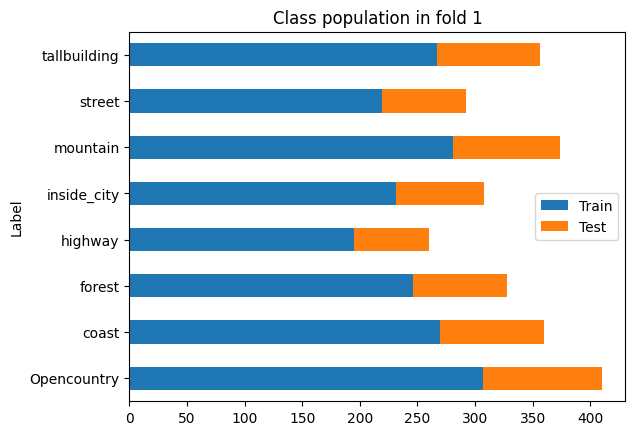

Fold Nº 2/4


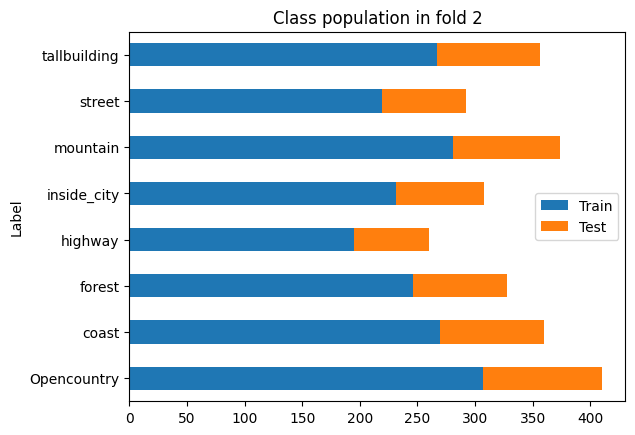

Fold Nº 3/4


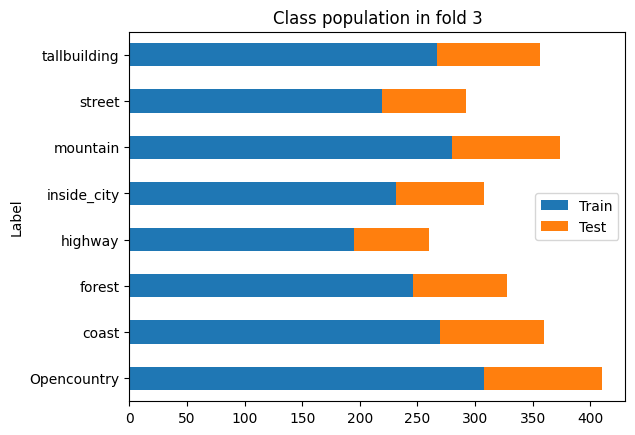

Fold Nº 4/4


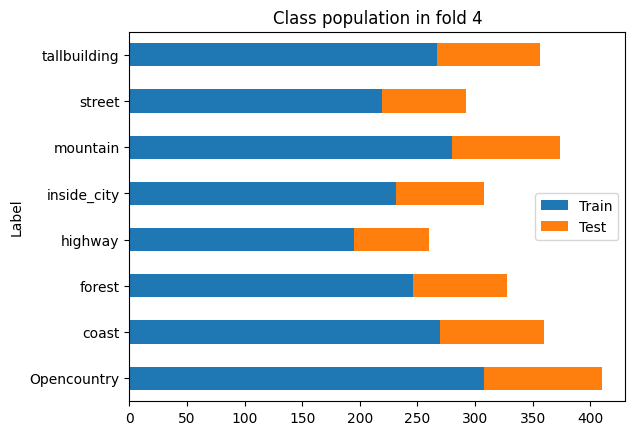

In [17]:
from sklearn.model_selection import StratifiedKFold

k_folds = 4
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(descriptors, labels)):
    print(f'Fold Nº {fold+1}/{k_folds}')
    train_descriptors, train_labels = descriptors[train_ids], labels[train_ids]
    test_descriptors, test_labels = descriptors[test_ids], labels[test_ids]
    plot_stratified_fold(train_labels, test_labels, fold+1)

In [20]:
def cross_validate(descriptors, labels, k_codebook=128, n_neighbours=5, knn_distance="euclidean", pca_components=64, lda_components=7, kernel="linear", plot_prints=False, plot_matrix=False, classifier="svm", images_filenames=None):
    accuracies = []
    pca_accuracies = []
    lda_accuracies = []
    for fold, (train_ids, test_ids) in enumerate(kfold.split(descriptors, labels)):
        print(f'Fold Nº {fold+1}/{k_folds}')
        train_descriptors, train_labels = descriptors[train_ids], labels[train_ids]
        test_descriptors, test_labels = descriptors[test_ids], labels[test_ids]
        D = np.vstack(train_descriptors)
        codebook = compute_codebook(D, k_codebook)
        visual_words = compute_visual_words(codebook, train_descriptors, k_codebook)

        model = train(train_labels, visual_words, n_neighbours, knn_distance, kernel, classifier)
        visual_words_test, accuracy = test(test_descriptors, test_labels, model, codebook, k_codebook, plot_matrix=plot_matrix, plot_prints=plot_prints, images_filenames=images_filenames)

        pca_accuracy = test_pca(train_labels, test_labels, visual_words, visual_words_test, pca_components, n_neighbours, knn_distance, plot_prints=plot_prints, classifier=classifier, kernel=kernel)
        lda_accuracy = test_lda(train_labels, test_labels, visual_words, visual_words_test, lda_components, n_neighbours, knn_distance, plot_prints=plot_prints, classifier=classifier, kernel=kernel)
        accuracies.append(accuracy)
        pca_accuracies.append(pca_accuracy)
        lda_accuracies.append(lda_accuracy)

    return np.mean(accuracies), np.mean(pca_accuracies), np.mean(lda_accuracies), [train_labels, test_labels, visual_words, visual_words_test]

# 9. Previous Experiments to recompute descriptors
Here we will find the best size of the image and step to precompute the descriptors for future experiments

## 9.1. Dense SIFT scale experiment
In this experiment we will compare the results of dense SIFT when performed with input images with different scales.

In [75]:
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
k_codebook = 128
n_neighbours = 5
knn_distance = "euclidean"
pca_components = 64
lda_components = 7
images_filenames, labels = read_dataset()

In [76]:
#plot results of accuracy output of chaning the scale of the input image
# Test different values of scale_percent = 100
accuracies = []
lda_accuracies = []
pca_accuracies = []

scale_percent_range = range(25, 150,25)
for scale_percent in scale_percent_range:
    print(f"Size of the images: {scale_percent}%")
    start_time = time.time()
    descriptors, labels = compute_descriptors(images_filenames, labels, des_type, step, n_features, scale_percent = scale_percent)
    print("Elapsed time to compute descriptors: ", time.time()-start_time, " seconds")
    start_time = time.time()
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)
    print("Elapsed time to make cross_valid: ", time.time()-start_time, " seconds")


Size of the images: 25%
Elapsed time to compute descriptors:  42.189738273620605  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  47.64942812919617  seconds
Size of the images: 50%
Elapsed time to compute descriptors:  43.02945947647095  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  41.956037521362305  seconds
Size of the images: 75%
Elapsed time to compute descriptors:  43.31070137023926  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  46.47491931915283  seconds
Size of the images: 100%
Elapsed time to compute descriptors:  38.806833028793335  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  49.791767835617065  seconds
Size of the images: 125%
Elapsed time to compute descriptors:  43.0349645614624  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  41.876970052719116  seconds

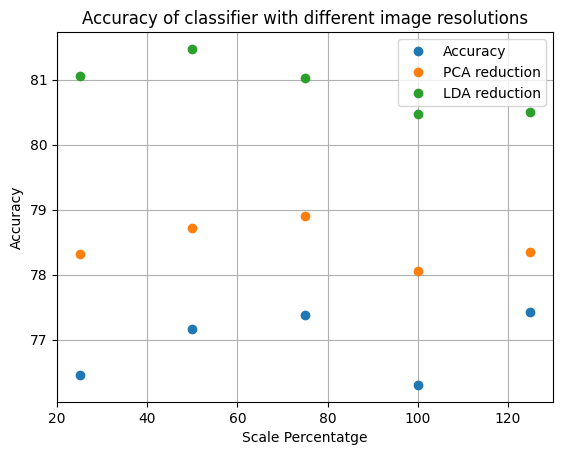

In [77]:
# Plot
fig, ax = plt.subplots()
ax.plot(scale_percent_range, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(scale_percent_range, pca_accuracies, linestyle='None', marker='o', label='PCA reduction')
ax.plot(scale_percent_range, lda_accuracies, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel("Scale Percentatge")
ax.set_ylabel('Accuracy')
plt.title("Accuracy of classifier with different image resolutions")

ax.legend()
plt.grid()
plt.show()

As we can see in the output of the cell above, the size of the images doesn't affect much on the execution time, just a little bit faster on low resolution images. Moreover, we can see in the graphic above that the accuracy of using Dense SIFT at different resolutions of the image doesn't vary much either, just between 81 and 82.

Conclusion: We will use original size images for all the experiments as it doesn't affect on the final result, except for the "9.2. Dense SIFT step experiment", as we need to use a lowscaled image to avoid memory errors.

## 9.2. Dense SIFT step experiment


In [78]:
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
n_features = None #None for all features
images_filenames, labels = read_dataset()

We can not test this experiment with a size step of less than 8 as our personal computer gets a MemoryError, even though we have tried using images with 25% size compared to the original one.

In [79]:
#plot results of accuracy output of chaning the scale of the input image
# Test different values of scale_percent = 100
accuracies = []
lda_accuracies = []
pca_accuracies = []

step_range = range(8, 140,12)
for step in step_range:
    print(f"Size of the step: {step}")
    start_time = time.time()
    descriptors, labels = compute_descriptors(images_filenames, labels, des_type, step, n_features, scale_percent = 25)
    print("Elapsed time to compute descriptors: ", time.time()-start_time, " seconds")
    start_time = time.time()
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)
    print("Elapsed time to make cross_valid: ", time.time()-start_time, " seconds")

Size of the step: 8
Elapsed time to compute descriptors:  91.5081000328064  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  921.0376174449921  seconds
Size of the step: 20
Elapsed time to compute descriptors:  74.52501249313354  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  29.724531412124634  seconds
Size of the step: 32
Elapsed time to compute descriptors:  44.78246569633484  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  16.5392062664032  seconds
Size of the step: 44
Elapsed time to compute descriptors:  37.861520767211914  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  13.549137830734253  seconds
Size of the step: 56
Elapsed time to compute descriptors:  34.99505877494812  seconds
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Elapsed time to make cross_valid:  13.085739850997925  seconds
Size of the step: 6

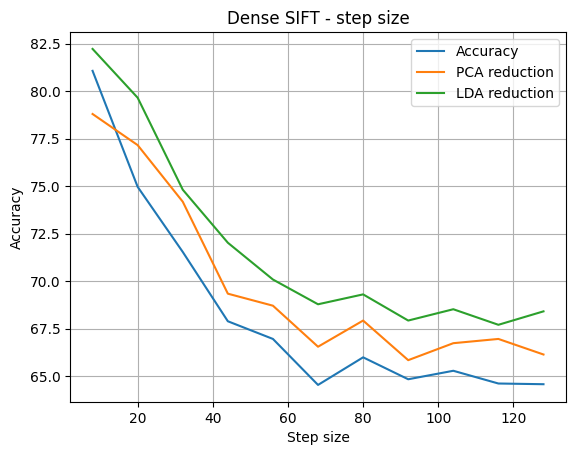

In [80]:
# Plot
fig, ax = plt.subplots()

ax.plot(step_range, accuracies, label='Accuracy')
ax.plot(step_range, pca_accuracies, label='PCA reduction')
ax.plot(step_range, lda_accuracies, label='LDA reduction')

ax.set_xlabel("Step size")
ax.set_ylabel("Accuracy")
plt.title("Dense SIFT - step size")

ax.legend()
plt.grid()
plt.show()

From the previous experiment we can see at first glance that having more than step_size higher than 16 is not worth, as we have an important decrease in accuracy. 

Having a small step size seems to have better results, as we increase the number of keypoints, and obtain more image information, although it is much more computationally expensive as we can see in the execution times. For instance, cross validating the step_size=8 lasted more than 20 minutes, while cross validating step_size=20 lasted less than 40 seconds. 

From the past experiment we conclude that the best option is having a step size of 16 as it achieves a top accuracy with a relatively fast execution time.

# 9.3 Precompute descriptors
Precomputing descriptors is necessary in order to avoid very long execution times, as the descriptors are the most time consuming task.

In [32]:
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
images_filenames, labels = read_dataset()
descriptors, labels = compute_descriptors(images_filenames, labels, des_type, step, n_features)

# 10. Experiments

In [72]:
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
k_codebook = 128
classifier = "svm"
kernel = "rbf"
n_neighbours = 5
knn_distance = "euclidean"
pca_components = 64
lda_components = 7

Plot the confusion matrix, and the ROC curve to analyze the results:

Fold Nº 1/4
acc: 74.40476190476191


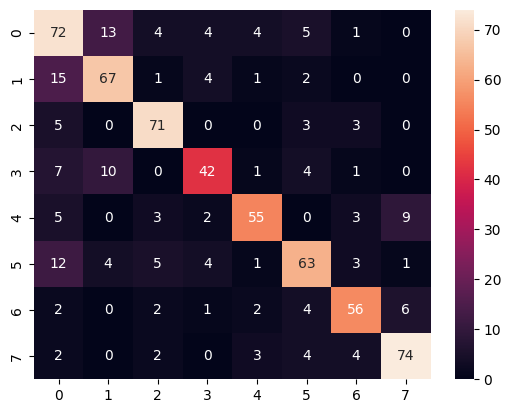

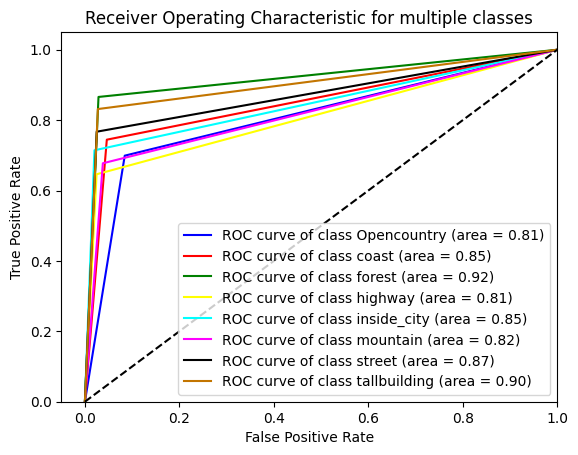

PCA reduction acc: 75.74404761904762
LDA reduction acc: 77.67857142857143
Fold Nº 2/4
acc: 75.59523809523809


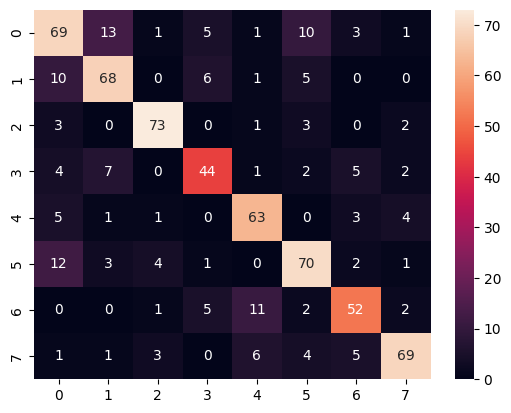

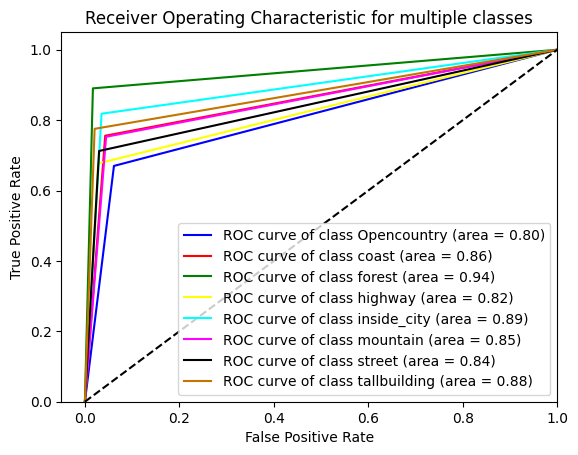

PCA reduction acc: 74.25595238095238
LDA reduction acc: 77.23214285714286
Fold Nº 3/4
acc: 78.125


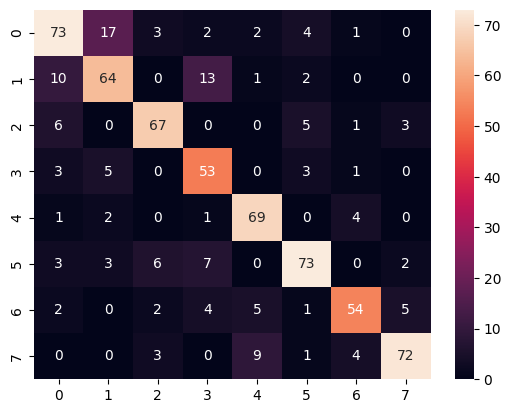

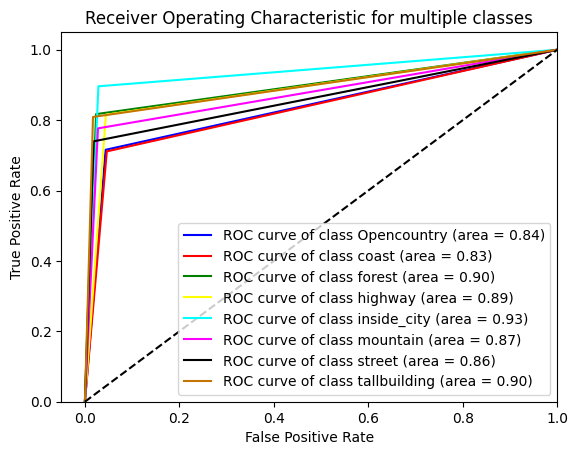

PCA reduction acc: 75.29761904761905
LDA reduction acc: 80.35714285714286
Fold Nº 4/4
acc: 73.36309523809523


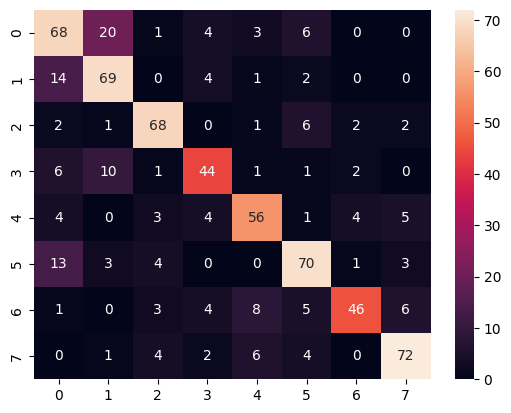

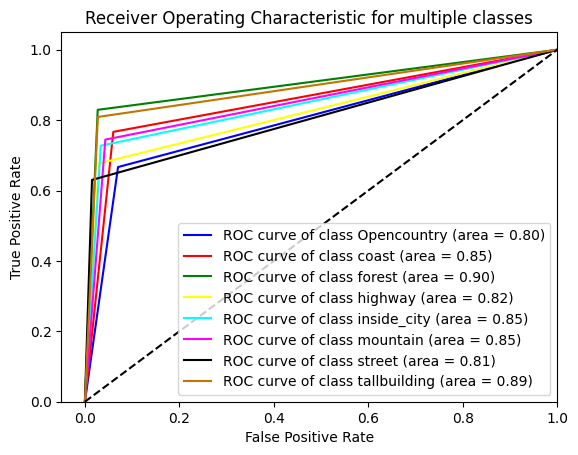

PCA reduction acc: 71.13095238095238
LDA reduction acc: 76.78571428571429
Mean: (75.37202380952381, 74.10714285714286, 78.01339285714286)


In [73]:
acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, pca_components, lda_components, plot_prints=True, plot_matrix=True, classifier=classifier, kernel=kernel)
print(f"Mean: {acc, pca_acc, lda_acc}")

Plot the test images of each fold so we can visually see results:

Fold Nº 1/4
acc: 77.23214285714286


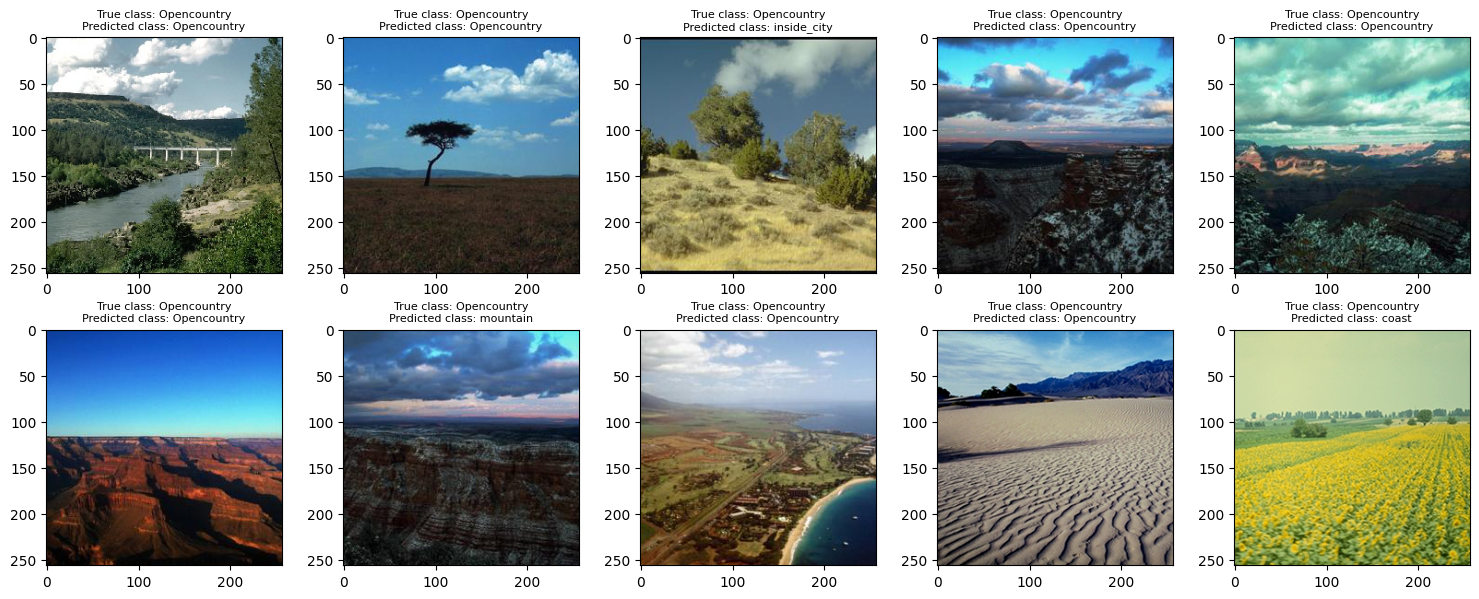

PCA reduction acc: 73.95833333333334
LDA reduction acc: 79.01785714285714
Fold Nº 2/4
acc: 77.82738095238095


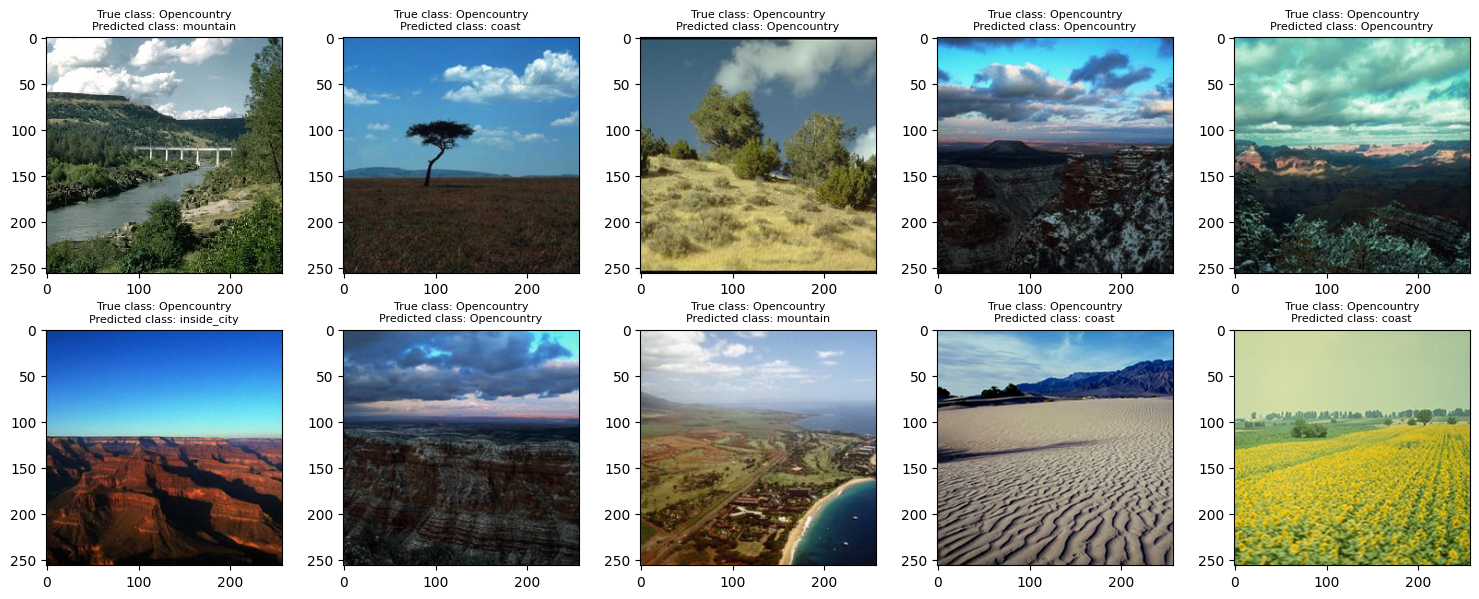

PCA reduction acc: 77.82738095238095
LDA reduction acc: 79.46428571428571
Fold Nº 3/4
acc: 78.125


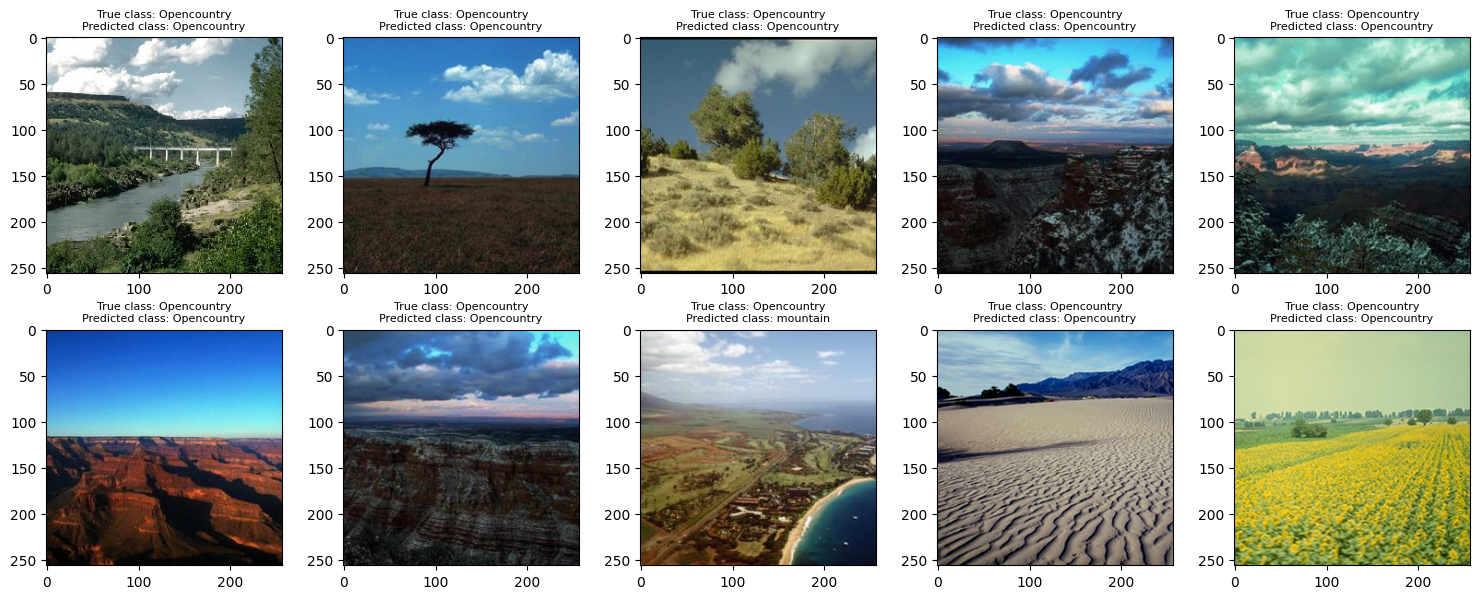

PCA reduction acc: 73.95833333333334
LDA reduction acc: 77.38095238095238
Fold Nº 4/4
acc: 76.04166666666666


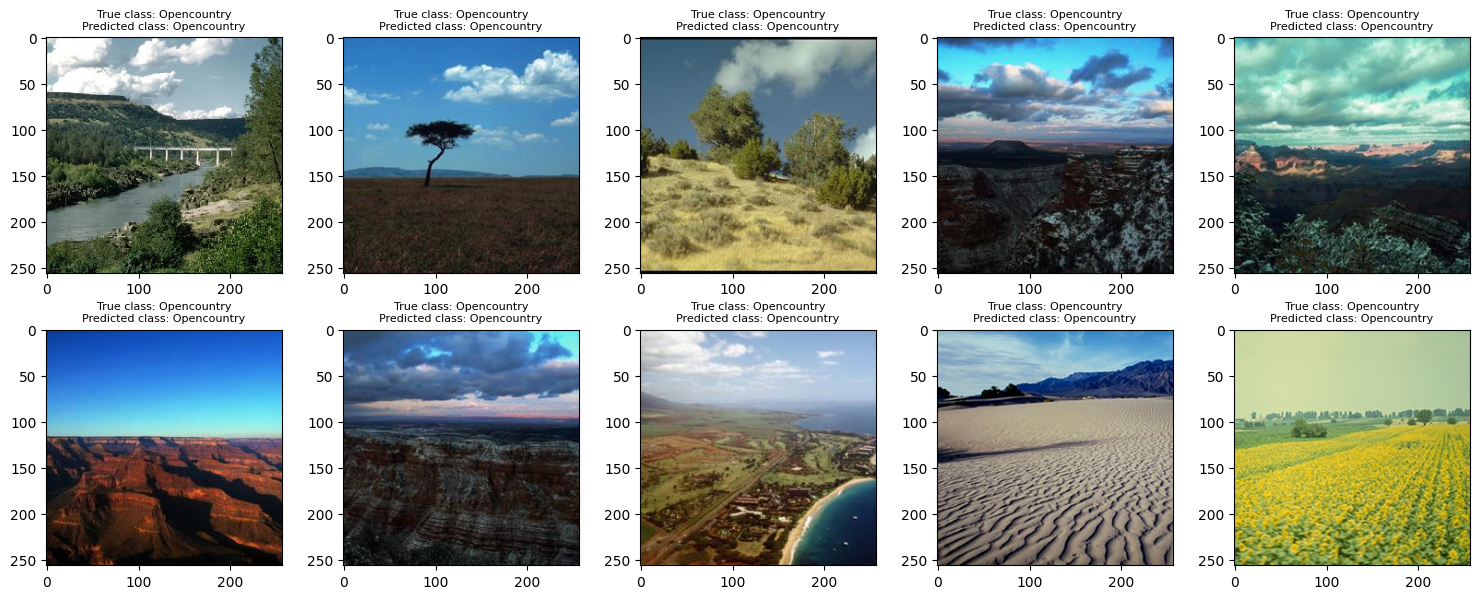

PCA reduction acc: 74.70238095238095
LDA reduction acc: 79.46428571428571
Mean: (77.30654761904762, 75.11160714285714, 78.83184523809523)


In [74]:
acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, pca_components, lda_components, plot_prints=True, images_filenames=images_filenames, classifier=classifier, kernel=kernel)
print(f"Mean: {acc, pca_acc, lda_acc}")

The results prove that the cross validation is consistent as the accuracy without dimensionality reduction and with PCA and LDA reduction always outputs very similar values in every fold.

## 10.1. Knn distances expertiment
Test with different distances i n the k-nn classifier:

In [69]:
k_codebook = 128
n_neighbours = 5
pca_components = 64
lda_components = 7
des_type = "SIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features

In [70]:
knn_distance_list = ["euclidean", "manhattan", "cosine"]
accuracies = []
pca_reductions = []
lda_reductions = []
for knn_distance in knn_distance_list:
    print("Knn Distance used: "+ knn_distance)
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

Knn Distance used: euclidean
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Knn Distance used: manhattan
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Knn Distance used: cosine
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


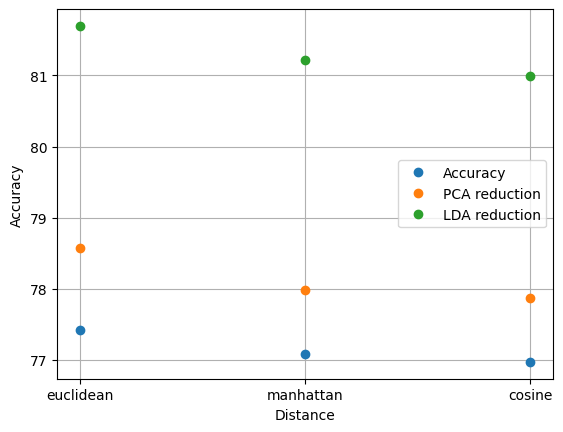

In [71]:
# Plot
fig, ax = plt.subplots()
ax.plot(knn_distance_list, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(knn_distance_list, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(knn_distance_list, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Distance')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

**Test other distances in k-nn classifier. Does that make a difference? Why?**

If we don't take into account dimensionality reduction, cosine distances appear to be the best one. On the other hand, Euclidean distance is the best if LDA reduction is used. Also LDA reduction improves a lot the accuracy of all the different distances in a k-nn classifier, whereas PCA reduction just improves by 1% the accuracy of Euclidean and Manhattan distance, and scores worst accuracy on cosine distance.

Euclidean distance is the most common choice and is a good default option. It works well when the data is uniformly distributed and the features have the same scale.

Manhattan distance works well when the features have different scales and the data is not uniformly distributed, which is not our case, as we can see in both the data and the accuracy results (without dimensionality changes).

Cosine distance is also a good option, as it works with data that is represented in the form of vectors. It measures the similarity between two vectors based on the cosine of the angle between them, rather than the Euclidean distance between their components.


## 10.2. Different descriptors expertiment
Test with different descriptors:

In [66]:
k_codebook = 128
pca_components = 64
lda_components = 7
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features

In [67]:
des_type_list = ["SIFT", "KAZE", 'ORB', 'AKAZE',"DSIFT"]
accuracies = []
pca_reductions = []
lda_reductions = []
for des_type in des_type_list:
    print("DESCRIPTOR: "+ des_type)
    descriptors_aux, labels_aux = compute_descriptors(images_filenames, labels, des_type, step, n_features)
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors_aux, labels_aux, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)

    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

DESCRIPTOR: SIFT
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR: KAZE
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR: ORB
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR: AKAZE
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR: DSIFT
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


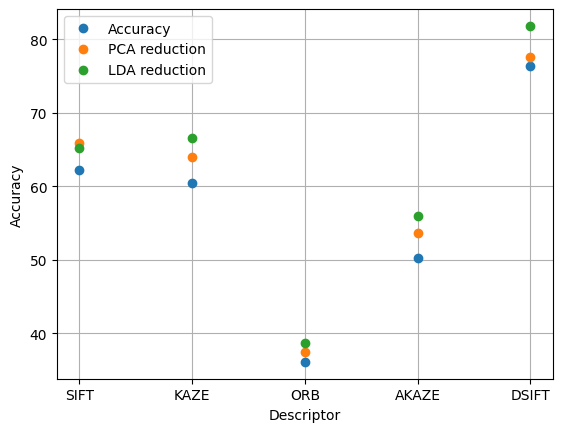

In [68]:
# Plot
fig, ax = plt.subplots()
ax.plot(des_type_list, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(des_type_list, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(des_type_list, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Descriptor')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

**Use dense SIFT instead of detected keypoints. Conclusions?**

In our case we have tried the following descriptors to identify and match keypoints in images:

SIFT is invariant to image scaling, rotation, and affine distortion, and is robust to changes in illumination and partial occlusion. SIFT is widely used in computer vision and image processing applications.

DSIFT (Dense SIFT) is a variant of SIFT that computes SIFT features at a dense set of points across an image. This can be useful for tasks such as image classification, where it is often important to consider the overall layout and structure of an image, which is our case.

KAZE is a keypoint descriptor that is based on the KAZE image feature detector. It uses a diffusion process to identify stable keypoints, and is robust to noise and affine distortion.

ORB is a keypoint descriptor that is designed to be fast and efficient. It combines the FAST corner detector with the BRIEF descriptor, and is rotation invariant. ORB is often used in applications where real-time performance is important, which is not our case.

AKAZE (Accelerated KAZE) is another keypoint descriptor that is based on the KAZE feature detector. It uses an accelerated version of the KAZE diffusion process to identify stable keypoints, and is robust to noise and affine distortion. AKAZE is often used in applications where real-time performance is important.

As we can see in the explanation before, and the plot of the accuracies each of these descriptors has given, we can see that Dense SIFT is the best one for our application, being better than its predecessor, and way better than the rest, which are not dense, and more focused on being fast, for example for real-time applications.

To make image classification, in our case, all the features of an image are important, not just a corner, but objects, colors, etc., which is why DSIFT has proven to be the best. Nonetheless, it is way slower than the others.

## 10.3. Reducing dimensionality experiment

In [63]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features

In [64]:
#get the last partition.
train_images_filenames, test_images_filenames, train_labels, test_labels = read_train_test()
acc, pca_acc, lda_acc, dataset_list = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components, plot_prints=False, plot_matrix=False)
train_labels, test_labels, visual_words, visual_words_test = dataset_list


Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


Play with reducing dimensionality:

PCA reduction acc: 35.11904761904761
LDA reduction acc: 35.86309523809524
PCA reduction acc: 62.5
LDA reduction acc: 65.02976190476191
PCA reduction acc: 67.41071428571429
LDA reduction acc: 72.47023809523809
PCA reduction acc: 68.75
LDA reduction acc: 77.08333333333334
PCA reduction acc: 71.13095238095238
LDA reduction acc: 79.16666666666666
PCA reduction acc: 73.51190476190477
LDA reduction acc: 79.46428571428571
PCA reduction acc: 73.21428571428571
LDA reduction acc: 80.50595238095238
PCA reduction acc: 73.21428571428571
PCA reduction acc: 72.47023809523809
PCA reduction acc: 74.10714285714286
PCA reduction acc: 75.89285714285714
PCA reduction acc: 75.14880952380952
PCA reduction acc: 74.70238095238095
PCA reduction acc: 73.95833333333334
PCA reduction acc: 76.19047619047619
PCA reduction acc: 76.78571428571429
PCA reduction acc: 77.38095238095238
PCA reduction acc: 77.52976190476191
PCA reduction acc: 77.97619047619048


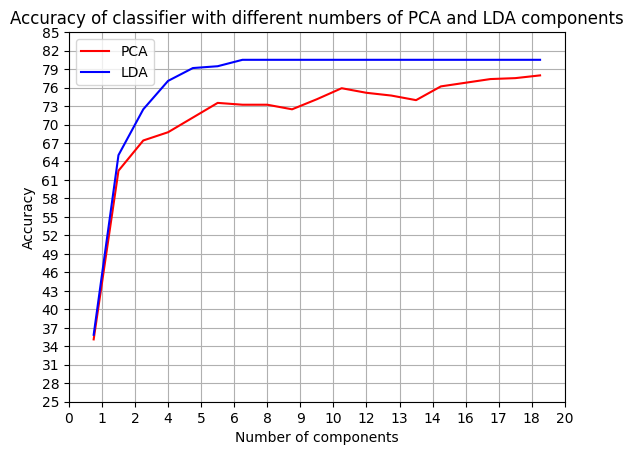

In [65]:
#plot results of accuracy output of test_pca and test_lda function changing the n_components
# Test different values of n_components
accuracies_pca = []
accuracies_lda = []

n_components_values = range(1, 20)
for n_components in n_components_values:
    accuracy_pda = test_pca(train_labels, test_labels, visual_words, visual_words_test, n_components)
    if n_components <= 8 - 1: #nclasses = 8
        accuracy_lda = test_lda(train_labels, test_labels, visual_words, visual_words_test, min(n_components, 8 - 1)) #nclasses = 8
    else:
        accuracy_lda= accuracies_lda[-1]
    accuracies_pca.append(accuracy_pda)
    accuracies_lda.append(accuracy_lda)

# Plot the results
plt.plot(n_components_values, accuracies_pca, color='red', label='PCA')
plt.plot(n_components_values, accuracies_lda, color='blue', label='LDA')

plt.xlabel("Number of components")
xticks = np.linspace(0, 20, 16)
xlabels = [str(int(xtick)) for xtick in xticks]
plt.xticks(xticks, xlabels)

plt.ylabel("Accuracy")
yticks = np.linspace(25, 85, 21)
ylabels = [str(int(ytick)) for ytick in yticks]
plt.yticks(yticks, ylabels)

plt.legend()

plt.title("Accuracy of classifier with different numbers of PCA and LDA components")
plt.grid()
plt.show()

**Play with reducing dimensionality. Conclusions?**

Linear Discriminant Analysis (LDA) and Probabilistic Discriminant Analysis (PDA) are both methods that can be used to reduce the dimensionality of data in an image classification problem. LDA and PDA both try to find a set of dimensions that are most informative for distinguishing between different classes in the data.

LDA has proven to be the best method in our case. This is likely because it was able to find a set of dimensions that were more effective at discriminating between the different classes in our data. This may be because LDA was able to capture more of the underlying structure of the data, or because it was able to better separate the different classes in the lower-dimensional space.

From the previous graph, we can see that LDA works better with the lda_components set to the maximum possible (number of classes), which is 7. PDA has also shown to reach almost the peak accuracy around 7 components, slightly improving if more components were chosen.

Both LDA and PDA were able to improve the accuracy of our classifier (without reducing dimensionality) as they were able to provide a better representation of the data that was more conducive to accurate classification. This could be because the original high-dimensional representation of the data was not very informative or because it contained a lot of noise.

## 10.4. Different amounts of local features experiment
Test different amounts of local features:

In [60]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors

In [61]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []

n_featuresrange = range(0, 1500,200)
for n_features in n_featuresrange:
    descriptors_aux, labels_aux = compute_descriptors(images_filenames, labels, des_type, step, n_features)
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors_aux, labels_aux, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


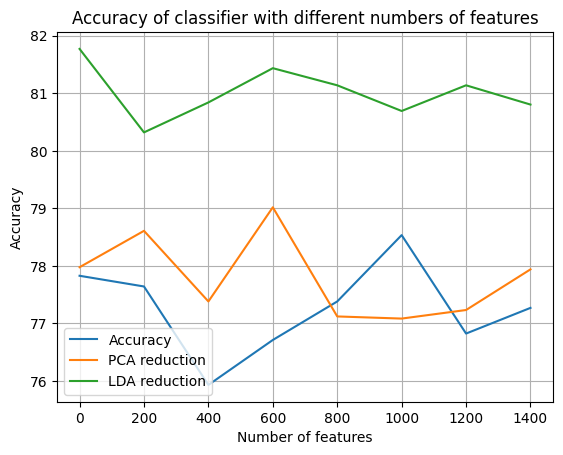

In [62]:
# Plot
fig, ax = plt.subplots()

ax.plot(n_featuresrange, accuracies, label='Accuracy')
ax.plot(n_featuresrange, pca_accuracies, label='PCA reduction')
ax.plot(n_featuresrange, lda_accuracies, label='LDA reduction')

ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of features")

ax.legend()
plt.grid()
plt.show()

**Test different amounts of local features. What performs best?**

Changing the number of local features detected by SIFT can affect the performance of the algorithm in a these ways:

Matching accuracy: SIFT uses the local features and their corresponding descriptors to match features between images. If the number of features is too small, there may not be enough distinctive points to accurately match the images. On the other hand, if the number of features is too large, the matching process may become computationally expensive and may not provide any additional benefit in terms of matching accuracy.

Computational cost: SIFT is a computationally intensive algorithm, and increasing the number of features will increase the computational cost of the algorithm.

As we can see from the previous graph, we can find the best amount of local features around 600 local features, which is the one that have a better balance between accuracy and computational cost.

## 10.5. Different amounts of codebook sizes experiment
Test different codebook sizes:

In [57]:
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features

In [58]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []
k_codebook_range = range(64, 350,32)
for k_codebook in k_codebook_range:
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


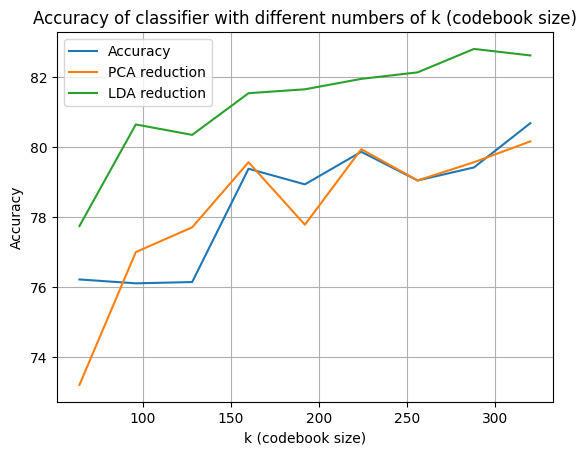

In [59]:
# Plot
fig, ax = plt.subplots()

ax.plot(k_codebook_range, accuracies, label='Accuracy')
ax.plot(k_codebook_range, pca_accuracies, label='PCA reduction')
ax.plot(k_codebook_range, lda_accuracies, label='LDA reduction')

ax.set_xlabel("k (codebook size)")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of k (codebook size)")

ax.legend()
plt.grid()
plt.show()

**Test different amounts of codebook sizes k. What performs best?**

The codebook size determines the size of the set of words that the algorithm uses to represent the images. The larger the codebook the more words used to represent the image and as a result a more accurate representation should be achieved, but it may take longer to process.

In this case, using SIFT descriptors, we see how it tends to achieve a better accuracy the larger the codebook.

## 10.6. Different amounts of k for the k-nn classifier experiment
Test different k for the k-nn classifier:

In [54]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features

In [55]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []
k_knn_range = range(1,20)
for n_neighbours in k_knn_range:
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


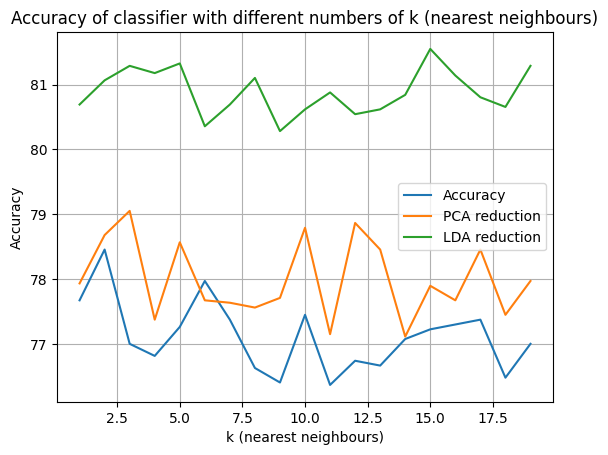

In [56]:
# Plot
fig, ax = plt.subplots()

ax.plot(k_knn_range, accuracies, label='Accuracy')
ax.plot(k_knn_range, pca_accuracies, label='PCA reduction')
ax.plot(k_knn_range, lda_accuracies, label='LDA reduction')

ax.set_xlabel("k (nearest neighbours)")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of k (nearest neighbours)")

ax.legend()
plt.grid()
plt.show()

**Test different values of k for the k-nn classifier. What performs best?**

The optimal value of k can depend on the characteristics of the dataset and the specific classification task. In general, a small value of k (e.g., k=1) may be more prone to overfitting, while a larger value of k (e.g., k=5 or k=10) may be more resistant to overfitting but may be less sensitive to the individual patterns in the data.

In our case, the number of k of the k-nn classifier that performs the best, and avoids underfitting and overfitting, could be k=15 for example.


## 10.7. Normalize descriptors experiment
In this experiment we will compare the original descriptor, the l2-normalized descriptor, and the Power-norm descriptor.

In [41]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
descriptors, labels = compute_descriptors(images_filenames, labels, des_type, step, n_features)

In [44]:
normalization_type_list = ["L1", "L2", 'No_normalization']
accuracies = []
pca_reductions = []
lda_reductions = []
for normalization_type in normalization_type_list:
    print("DESCRIPTOR normalized by: "+ normalization_type)
    if normalization_type == 'No_normalization':
        acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
    else:
        norm_descriptors = normalize_descriptors(descriptors, norm="L1")
        acc, pca_acc, lda_acc, _ = cross_validate(norm_descriptors, labels, k_codebook, n_neighbours, knn_distance, pca_components, lda_components)
        
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

DESCRIPTOR normalized by: L1
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR normalized by: L2
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4
DESCRIPTOR normalized by: No_normalization
Fold Nº 1/4
Fold Nº 2/4
Fold Nº 3/4
Fold Nº 4/4


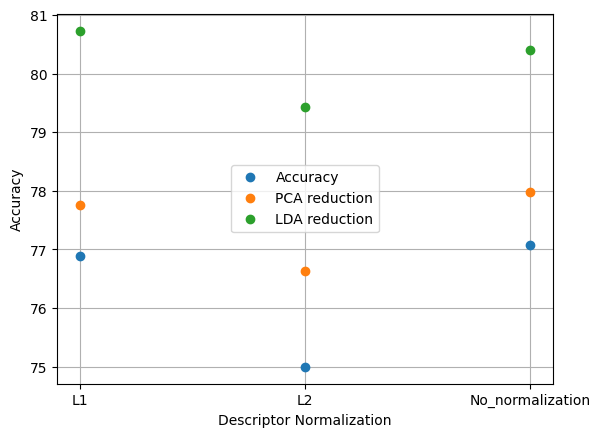

In [45]:
# Plot
fig, ax = plt.subplots()
ax.plot(normalization_type_list, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(normalization_type_list, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(normalization_type_list, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Descriptor Normalization')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

As we can see in the graphic above, if no dimensionality reduction is done, not doing any kind of normalization to the data appears to be the best. Nonetheless, if we use LDA dimensionality reduction, L1 normalization is slightly better than the others.

# 10.8. SVM kernel emperiment

Test with different svm kernels:

In [50]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
classifier = "svm"

In [51]:
def histogram_intersection(data_1, data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))
    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)
    return kernel

In [52]:
kernels = ["rbf", "linear", "intersection"]
accuracies = []
pca_reductions = []
lda_reductions = []

for kernel in kernels:
    if kernel == "intersection":
        kernel = histogram_intersection
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors, labels, k_codebook, pca_components=pca_components, lda_components=lda_components, kernel=kernel, plot_prints=True, plot_matrix=False, classifier=classifier)
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

Fold Nº 1/4
acc: 79.31547619047619
PCA reduction acc: 78.27380952380952
LDA reduction acc: 78.86904761904762
Fold Nº 2/4
acc: 86.16071428571429
PCA reduction acc: 84.375
LDA reduction acc: 83.48214285714286
Fold Nº 3/4
acc: 80.05952380952381
PCA reduction acc: 78.42261904761905
LDA reduction acc: 79.91071428571429
Fold Nº 4/4
acc: 81.69642857142857
PCA reduction acc: 79.91071428571429
LDA reduction acc: 80.05952380952381
Fold Nº 1/4
acc: 74.85119047619048
PCA reduction acc: 76.63690476190477
LDA reduction acc: 82.14285714285714
Fold Nº 2/4
acc: 79.01785714285714
PCA reduction acc: 78.125
LDA reduction acc: 82.88690476190477
Fold Nº 3/4
acc: 77.52976190476191
PCA reduction acc: 77.97619047619048
LDA reduction acc: 80.80357142857143
Fold Nº 4/4
acc: 76.93452380952381
PCA reduction acc: 77.67857142857143
LDA reduction acc: 81.39880952380952
Fold Nº 1/4
acc: 79.46428571428571
PCA reduction acc: 78.72023809523809
LDA reduction acc: 80.35714285714286
Fold Nº 2/4
acc: 80.05952380952381
PCA re

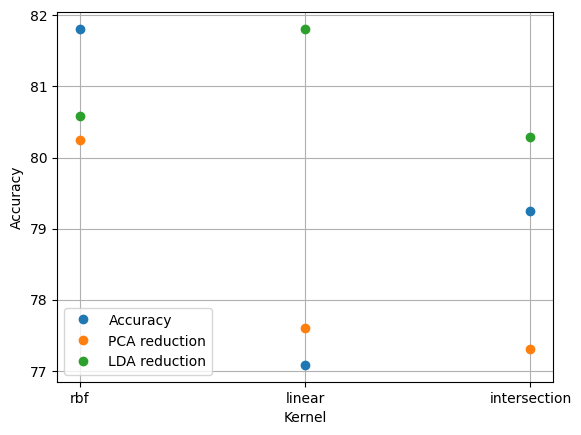

In [53]:
# Plot
fig, ax = plt.subplots()
ax.plot(kernels, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(kernels, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(kernels, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Kernel')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

As we can see in the previous graphic, rbf kernel appears to be the best in this case, achiving an accuracy of 82%. We can also notice that in this particular case it is not worth to use dimensionality reduction, as we lose accuracy.

# 10.9. Spatial pyramid experiment

In [46]:
k_codebook = 128
pca_components = 64
lda_components = 7
des_type = "DSIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 16  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
n_features = None #None for all features
classifier = "svm"
kernel = "rbf"

In [48]:
accuracies = []
pca_reductions = []
lda_reductions = []

levels = ["1","2","3","4","5"]
for level in levels:
    print("Pyramid level = "+ level)
    descriptors_pyramid, labels_pyramid = compute_descriptors_pyramid(images_filenames, labels, des_type, step, n_features, level=int(level))
    acc, pca_acc, lda_acc, _ = cross_validate(descriptors_pyramid, labels_pyramid, k_codebook, pca_components=pca_components, lda_components=lda_components, kernel=kernel, plot_prints=True, plot_matrix=False, classifier=classifier)
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

Fold Nº 1/4
acc: 80.65476190476191
PCA reduction acc: 79.16666666666666
LDA reduction acc: 81.39880952380952
Fold Nº 2/4
acc: 82.14285714285714
PCA reduction acc: 81.25
LDA reduction acc: 82.73809523809523
Fold Nº 3/4
acc: 80.80357142857143
PCA reduction acc: 82.44047619047619
LDA reduction acc: 81.69642857142857
Fold Nº 4/4
acc: 81.54761904761905
PCA reduction acc: 78.57142857142857
LDA reduction acc: 79.91071428571429
Fold Nº 1/4
acc: 76.63690476190477
PCA reduction acc: 77.67857142857143
LDA reduction acc: 74.70238095238095
Fold Nº 2/4
acc: 78.72023809523809
PCA reduction acc: 76.19047619047619
LDA reduction acc: 77.23214285714286
Fold Nº 3/4
acc: 79.01785714285714
PCA reduction acc: 78.27380952380952
LDA reduction acc: 76.93452380952381
Fold Nº 4/4
acc: 75.29761904761905
PCA reduction acc: 73.95833333333334
LDA reduction acc: 75.44642857142857
Fold Nº 1/4
acc: 73.06547619047619
PCA reduction acc: 71.72619047619048
LDA reduction acc: 71.13095238095238
Fold Nº 2/4
acc: 73.06547619047

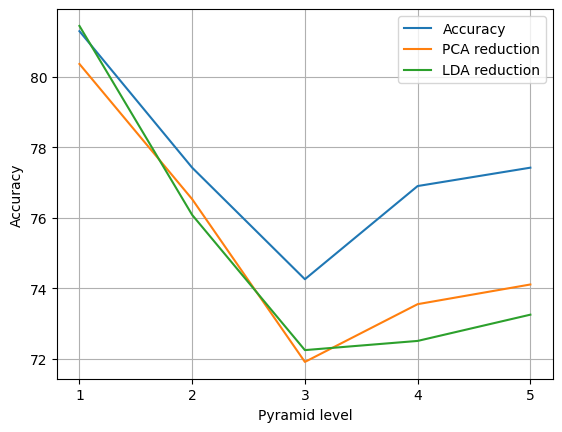

In [49]:
# Plot
fig, ax = plt.subplots()
ax.plot(levels, accuracies, label='Accuracy')
ax.plot(levels, pca_reductions, label='PCA reduction')
ax.plot(levels, lda_reductions, label='LDA reduction')
ax.set_xlabel('Pyramid level')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

As we can see in the graphic above, it is not worth to divide the image into subimages, as the execution time increase exponentially, and the results in accuracy do not improve respect to the original size.